**Network Intrusion Detection with PyOD 2: Model Performance Comparison on Cybersecurity Dataset**

In [1]:
#!pip install -U pyod

- This will install the latest version, which is PyOD2+, and includes everything we need
- “PyOD2” is an informal reference to pyod version 1.0+ (sometimes called PyOD 2.0).

It includes:

- Better API design
- Expanded model library
- Deep learning models support (e.g., AutoEncoder, VAE)
- Improved integration with scikit-learn, torch, etc.

In [2]:
import pyod
print("PyOD version:", pyod.__version__)

PyOD version: 2.0.5


**Imports and Utilities**
- This section includes all core libraries and helper utilities required across the notebook.

In [3]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import json

from pyod.utils.data import evaluate_print
from sklearn.metrics import roc_auc_score
from tabulate import tabulate
from scipy.io import loadmat

# PyOD Model Imports
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.devnet import DevNet
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

**Data Loading (Dataset Loader for .mat dataset files)**

- Utility to load `.mat` dataset files in the format used by PyOD benchmark datasets.

In [4]:
def load_mat_dataset(filepath):
    """
    Load .mat dataset and return features (X) and labels (y).
    As .mat format has 'X' and 'y' or similar keys.
    """
    data = loadmat(filepath)
    X = data.get("X") or data.get("x")
    y = data.get("y") or data.get("Y")
    if y is not None:
        y = y.flatten()
    return X, y

In [5]:
def load_mat_dataset(filepath):
    """
    Load .mat dataset and return features (X) and labels (y).
    """
    data = loadmat(filepath)
    
    # Fix: safely check for keys
    X = data.get("X") if "X" in data else data.get("x")
    y = data.get("y") if "y" in data else data.get("Y")
    
    # Flatten y if needed
    if y is not None and len(y.shape) > 1 and y.shape[1] == 1:
        y = y.ravel()

    return X, y


**CSV Loader Support**

In [6]:
def load_csv_dataset(filepath, label_col="label"):
    """
    Load dataset from CSV and return features (X) and labels (y).
    'label' is the target column.
    """
    df = pd.read_csv(filepath)
    if label_col not in df.columns:
        raise ValueError(f"'{label_col}' not found in dataset.")
    
    y = df[label_col].values
    X = df.drop(columns=[label_col]).values
    return X, y

**Basic EDA for External Dataset**

In [7]:
def basic_eda_and_cleaning(df, target_col='label'):
    print("EDA & Cleaning Summary:")
    print("-" * 40)
    print(f"Shape: {df.shape}")
    print("\nMissing values:\n", df.isnull().sum())

    # Drop missing rows
    df_clean = df.dropna()

    # Check target distribution
    print("\nTarget distribution:", df_clean[target_col].value_counts().to_dict())

    # Identify column types
    numeric_cols = df_clean.select_dtypes(include='number').columns.tolist()
    categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()
    
    print(f"\nNumeric features: {len(numeric_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")

    return df_clean

**Wrapper loader function** **General Dataset Loader**
- A unified function to handle both .mat and .csv files

In [8]:
def load_dataset(filepath, filetype="mat", label_col="label"):
    """
    Load dataset based on type: 'mat' or 'csv'
    """
    if filetype == "mat":
        return load_mat_dataset(filepath)
    elif filetype == "csv":
        return load_csv_dataset(filepath, label_col)
    else:
        raise ValueError("Unsupported filetype. Use 'mat' or 'csv'.")

**Dataset Profiling & Auto Tagging**
- Profiles the dataset and generates interpretable tags (e.g., `highly_imbalanced`, `structured_data`, `low_noise`, etc.)

In [9]:
def profile_dataset_and_assign_tags(X, y):
    n_samples, n_features = X.shape
    anomaly_ratio = np.mean(y)
    missing_ratio = np.isnan(X).sum() / (n_samples * n_features)
    
    skewness = stats.skew(X, axis=0, nan_policy="omit")
    kurtosis = stats.kurtosis(X, axis=0, nan_policy="omit")
    avg_skewness = np.nanmean(np.abs(skewness))
    avg_kurtosis = np.nanmean(np.abs(kurtosis))

    tags = []

    # Dimensionality
    if n_features <= 10:
        tags.append("low_dimensional")
    elif n_features <= 100:
        tags.append("medium_dimensional")
    else:
        tags.append("high_dimensional")

    # Sample Size
    if n_samples <= 500:
        tags.append("small_sample")
    elif n_samples <= 5000:
        tags.append("medium_sample")
    else:
        tags.append("large_sample")

    # Imbalance
    if anomaly_ratio < 0.05:
        tags.append("highly_imbalanced")
    elif anomaly_ratio < 0.20:
        tags.append("imbalanced")
    else:
        tags.append("balanced")

    # Noise Estimation
    if avg_skewness > 2.5 or avg_kurtosis > 10:
        tags.append("noisy")
    else:
        tags.append("low_noise")

    # Missing Data
    if missing_ratio > 0.1:
        tags.append("missing_data")

    # Structure assumption (tabular)
    tags.append("structured_data")

    # Build summary table
    metrics_df = pd.DataFrame({
        "Metric": [
            "n_samples", "n_features", "anomaly_ratio", 
            "missing_value_ratio", "avg_skewness", "avg_kurtosis"
        ],
        "Value": [
            n_samples, n_features, round(anomaly_ratio, 6), 
            round(missing_ratio, 6), round(avg_skewness, 4), 
            round(avg_kurtosis, 4)
        ]
    })

    print("Dataset Profiling Summary")
    display(metrics_df)

    print("\n Assigned Tags:", tags)
    return tags, metrics_df

In [10]:
# Loop and profile datasets

dataset_list = [
    {
        "name": "cardio",
        "path": "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/cardio.mat",
        "type": "mat"
    },
    {
        "name": "ionosphere",
        "path": "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/ionosphere.mat",
        "type": "mat"
    },
    {
        "name": "pima_diabetes",
        "path": "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/4-pima-indians-diabetes-2.csv",
        "type": "csv",
        "label_col": "class"  # Adjust as per actual label column
    }
]

# Store summary only (avoid storing X, y directly)
all_dataset_results = []

for ds in dataset_list:
    print(f"\n Processing Dataset: {ds['name']}")
    
    # Load dataset
    if ds["type"] == "csv":
        X, y = load_dataset(ds["path"], filetype="csv", label_col=ds.get("label_col", "label"))
    else:
        X, y = load_dataset(ds["path"], filetype="mat")
    
    # Profile dataset
    assigned_tags, metrics_df = profile_dataset_and_assign_tags(X, y)

    # Store summary (X, y not stored to avoid ambiguity)
    all_dataset_results.append({
        "name": ds["name"],
        "tags": assigned_tags,
        "metrics": metrics_df.to_dict(orient="records")  # Convert DF to simple dict list
    })



 Processing Dataset: cardio
Dataset Profiling Summary


,Metric,Value
0,n_samples,1831.000000
1,n_features,21.000000
2,anomaly_ratio,0.096122
3,missing_value_ratio,0.000000
4,avg_skewness,2.274400
5,avg_kurtosis,20.273300



 Assigned Tags: ['medium_dimensional', 'medium_sample', 'imbalanced', 'noisy', 'structured_data']

 Processing Dataset: ionosphere
Dataset Profiling Summary


,Metric,Value
0,n_samples,351.000000
1,n_features,33.000000
2,anomaly_ratio,0.358974
3,missing_value_ratio,0.000000
4,avg_skewness,0.612700
5,avg_kurtosis,0.632000



 Assigned Tags: ['medium_dimensional', 'small_sample', 'balanced', 'low_noise', 'structured_data']

 Processing Dataset: pima_diabetes
Dataset Profiling Summary


,Metric,Value
0,n_samples,768.000000
1,n_features,8.000000
2,anomaly_ratio,0.348958
3,missing_value_ratio,0.000000
4,avg_skewness,1.095200
5,avg_kurtosis,2.880600



 Assigned Tags: ['low_dimensional', 'medium_sample', 'balanced', 'low_noise', 'structured_data']


**Define Model Metadata (Model Tags)**

In [11]:
# Define model capabilities (symbolic tags)
MODEL_TAGS = {
    "auto_encoder": {
        "strengths": ["structured_data", "low_noise"],
        "weaknesses": ["noisy"]
    },
    "vae": {
        "strengths": ["structured_data", "low_noise"],
        "weaknesses": ["noisy"]
    },
    "iforest": {
        "strengths": ["structured_data", "imbalanced"],
        "weaknesses": ["small_sample"]
    },
    "lof": {
        "strengths": ["structured_data"],
        "weaknesses": ["high_dimensional"]
    },
    "devnet": {
        "strengths": ["structured_data"],
        "weaknesses": ["small_sample"]
    }
}

 your report or appendix. Want that?
n your report or appendix. Want that?


The **model tags** defined in above are conceptually aligned with the capabilities and descriptions of models available in **PyOD 2**, but they are **not directly provided by PyOD** as a structured dictionary.

**PyOD 2 Provides:**

- A **wide collection of models** from different families (e.g., proximity-based, probabilistic, neural, ensemble), but it doesn’t explicitly label each model with:

* 'strengths': where it works best
* 'weaknesses': where it struggles

So, the symbolic tags like '"low_noise"', '"structured_data"', '"small_sample"' etc., are **manually inferred** from:

* Research papers
* Model documentation (in PyOD and elsewhere)
* Practical experience with their behavior

This symbolic tagging lets us:

* Match **dataset characteristics** (tags) with **model capabilities**
* Perform a **quick symbolic match** before running expensive model training
* Justify choices (e.g., “this model is strong for low\_noise datasets, which matches the current dataset profile”)

**In Summary:**

| Source       | Description                                                      |
| ------------ | ---------------------------------------------------------------- |
| PyOD 2       | Provides models and their implementations                        |
| Our Code     | Assigns **symbolic metadata** (tags) based on external knowledge |
| Future Scope | These tags can be extended to more models as needed              |

**Model Tag Metadata Table (Top 10 PyOD Models)**
- for the top 10 PyOD models for reference and inclusion in our report or appendix

In [12]:
model_tag_dict = {
    "auto_encoder": {
        "strengths": ["structured_data", "low_noise", "medium_dimensional", "small_sample"],
        "weaknesses": ["noisy", "very_high_dimensional"]
    },
    "vae": {
        "strengths": ["structured_data", "low_noise", "medium_dimensional"],
        "weaknesses": ["small_sample", "noisy"]
    },
    "iforest": {
        "strengths": ["structured_data", "medium_dimensional", "small_sample"],
        "weaknesses": ["very_high_dimensional", "extremely_balanced"]
    },
    "lof": {
        "strengths": ["structured_data", "local_outliers", "medium_dimensional"],
        "weaknesses": ["very_large", "high_noise"]
    },
    "devnet": {
        "strengths": ["deep_outliers", "structured_data"],
        "weaknesses": ["small_sample", "imbalanced"]
    },
    "cblof": {
        "strengths": ["structured_data", "low_noise", "large_sample"],
        "weaknesses": ["very_small_sample"]
    },
    "kNN": {
        "strengths": ["structured_data", "local_outliers", "low_noise"],
        "weaknesses": ["high_dimensional", "large_sample"]
    },
    "HBOS": {
        "strengths": ["structured_data", "high_dimensional", "low_noise"],
        "weaknesses": ["noisy", "non_numerical"]
    },
    "PCA": {
        "strengths": ["low_noise", "structured_data", "high_dimensional"],
        "weaknesses": ["non_linear", "imbalanced"]
    },
    "COPOD": {
        "strengths": ["structured_data", "low_noise", "interpretability"],
        "weaknesses": ["non_numerical"]
    }
    
}

Each model is tagged with:
- Strengths → Data characteristics where the model typically performs well
- Weaknesses → Conditions that may reduce its performance

**Appendix:**

---

| Model         | Strengths                                   | Weaknesses                                   |
| ------------- | ------------------------------------------- | -------------------------------------------- |
| auto\_encoder | structured\_data, low\_noise, small\_sample | noisy, very\_high\_dimensional               |
| vae           | structured\_data, low\_noise                | small\_sample, noisy                         |
| iforest       | structured\_data, small\_sample             | very\_high\_dimensional, extremely\_balanced |
| lof           | structured\_data, local\_outliers           | very\_large, high\_noise                     |
| cblof         | structured\_data, low\_noise, large\_sample | very\_small\_sample                          |
| kNN           | structured\_data, low\_noise                | high\_dimensional, large\_sample             |
| HBOS          | structured\_data, high\_dimensional         | noisy, non\_numerical                        |
| PCA           | low\_noise, high\_dimensional               | non\_linear, imbalanced                      |
| COPOD         | structured\_data, interpretability          | non\_numerical                               |
| devnet        | deep\_outliers, structured\_data            | small\_sample, imbalanced                    |

---

**Symbolic Scoring Function**

In [13]:
def score_models_by_tags(dataset_tags, model_tag_dict):
    results = []
    for model, tags in model_tag_dict.items():
        score = 0
        explanation = []
        for tag in tags.get("strengths", []):
            if tag in dataset_tags:
                score += 1
                explanation.append(f"+1 for {tag}")
        for tag in tags.get("weaknesses", []):
            if tag in dataset_tags:
                score -= 1
                explanation.append(f"-1 for {tag}")
        results.append({
            "Model": model,
            "Symbolic Score": score,
            "Explanation": "; ".join(explanation)
        })
    return pd.DataFrame(results).sort_values(by="Symbolic Score", ascending=False).reset_index(drop=True)


**Load/Define Model Tags (with fallback)**

In [14]:
def load_model_tags(model_name):
    fallback_tags = {
        "auto_encoder": {"strengths": ["structured_data", "low_noise"], "weaknesses": ["noisy"]},
        "vae": {"strengths": ["structured_data", "low_noise"], "weaknesses": ["noisy"]},
        "devnet": {"strengths": ["highly_imbalanced", "structured_data"], "weaknesses": ["small_sample"]},
        "iforest": {"strengths": ["structured_data", "imbalanced"], "weaknesses": ["high_dimensional"]},
        "lof": {"strengths": ["structured_data"], "weaknesses": ["high_dimensional"]}
    }
    tag_path = f"model_tags/{model_name}.json"
    if os.path.exists(tag_path):
        with open(tag_path, "r") as f:
            return json.load(f)
    else:
        return fallback_tags.get(model_name, {"strengths": [], "weaknesses": []})


**Symbolic Scoring Function (with Looping)**

In [15]:
def symbolic_model_selector(dataset_tags, model_tags_dict, tag_weights, verbose=True):
    results = []
    for model_name, tags in model_tags_dict.items():
        score = 0
        reasoning = []
        for tag in dataset_tags:
            weight = tag_weights.get(tag, 1.0)
            if tag in tags.get('strengths', []):
                score += weight
                reasoning.append(f"+{weight} for {tag}")
            elif tag in tags.get('weaknesses', []):
                score -= weight
                reasoning.append(f"-{weight} for {tag}")
        results.append({
            "Model": model_name,
            "Symbolic Score": score,
            "Explanation": "; ".join(reasoning)
        })

    results_df = pd.DataFrame(sorted(results, key=lambda x: -x["Symbolic Score"]))

    if verbose:
        display(results_df)

    top_models = results_df[results_df["Symbolic Score"] == results_df["Symbolic Score"].max()]["Model"].tolist()

    gpt_prompt = f"""
Dataset Tags: {dataset_tags}

Model Tag Summaries:
{json.dumps(model_tags_dict, indent=2)}

Symbolic Scores:
{results_df.to_string(index=False)}

Do you agree with selecting **{top_models[0]}**? Why or why not?
""".strip()

    return results_df, gpt_prompt, top_models


**Tag Weights (Constant)**

In [16]:
# Optional: Adjust weights for certain tags if needed
TAG_WEIGHTS = {
    "low_noise": 1.0,
    "structured_data": 1.0,
    "balanced": 1.0,
    "small_sample": 0.8,
    "highly_imbalanced": 1.2,
    "noisy": 1.2,
    "high_dimensional": 1.1
}


**Symbolic Scoring + LLM Prompt (per dataset)**

In [17]:
# Define model tags (load from earlier or reuse across datasets)
model_keys = ["auto_encoder", "vae", "devnet", "iforest", "lof"]
model_tag_dict = {k: load_model_tags(k) for k in model_keys}
TAG_WEIGHTS = {  # Default weights, update if needed
    "low_noise": 1.5, "structured_data": 1.5,
    "small_sample": 1.2, "highly_imbalanced": 1.2,
}

def run_symbolic_scoring(tags, model_tag_dict, tag_weights=TAG_WEIGHTS):
    return symbolic_model_selector(tags, model_tag_dict, tag_weights)


**Train + Evaluate Models (per dataset)**

In [18]:
def evaluate_models(X, y, model_keys=None):
    
    model_constructors = {
        "auto_encoder": lambda: AutoEncoder(),
        "vae": lambda: VAE(),
        "devnet": lambda: DevNet(),
        "iforest": lambda: IForest(),
        "lof": lambda: LOF()
    }

    if model_keys is None:
        model_keys = list(model_constructors.keys())

    results = []

    for model_key in model_keys:
        print(f" Running {model_key}...", end=" ")
        try:
            clf = model_constructors[model_key]()

            # Training
            if model_key == "devnet":
                clf.fit(X, y)
            else:
                clf.fit(X)

            # Evaluation
            scores = clf.decision_scores_
            auc = roc_auc_score(y, scores)
            results.append({"Model": model_key, "AUC": auc})
            print(f"AUC: {auc:.4f}")

        except Exception as e:
            print(f" Failed: {e}")

    df_results = pd.DataFrame(results)
    if "AUC" in df_results.columns:
        return df_results.sort_values(by="AUC", ascending=False).reset_index(drop=True)
    else:
        print(" No AUC scores computed.")
        return df_results


In [19]:
auc_df = evaluate_models(X, y)

print(" AUC DataFrame columns:", auc_df.columns.tolist())
display(auc_df)


 Running auto_encoder... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


AUC: 0.6507
 Running vae... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.52it/s]


AUC: 0.5501
 Running devnet... Original training size: 768, No. outliers: 268
768 268 500 55
Epoch 1, Loss: -868.2748413085938
Epoch 2, Loss: -2117.755859375
Epoch 3, Loss: -3269.189453125
Epoch 4, Loss: -4629.8427734375
Epoch 5, Loss: -6136.95751953125
Epoch 6, Loss: -7440.6787109375
Epoch 7, Loss: -9400.2109375
Epoch 8, Loss: -11026.986328125
Epoch 9, Loss: -12683.2587890625
Epoch 10, Loss: -14212.822265625
Epoch 11, Loss: -16340.197265625
Epoch 12, Loss: -18481.953125
Epoch 13, Loss: -21375.287109375
Epoch 14, Loss: -22195.513671875
Epoch 15, Loss: -24502.015625
Epoch 16, Loss: -26109.83984375
Epoch 17, Loss: -29994.49609375
Epoch 18, Loss: -31015.658203125
Epoch 19, Loss: -33373.3984375
Epoch 20, Loss: -35009.0078125
Epoch 21, Loss: -38173.2421875
Epoch 22, Loss: -40523.7734375
Epoch 23, Loss: -42255.0546875
Epoch 24, Loss: -46372.3984375
Epoch 25, Loss: -45862.23046875
Epoch 26, Loss: -47910.703125
Epoch 27, Loss: -52434.33984375
Epoch 28, Loss: -54358.9140625
Epoch 29, Loss: -568

,Model,AUC
0,iforest,0.669746
1,auto_encoder,0.650709
2,vae,0.550142
3,lof,0.542396
4,devnet,0.339052


**LLM Audit Prompt Generator**

In [20]:
def generate_final_llm_audit(dataset_tags, model_tags_dict, symbolic_df, auc_df):
    top_score = symbolic_df["Symbolic Score"].max()
    top_models = symbolic_df[symbolic_df["Symbolic Score"] == top_score]["Model"].tolist()
    tied_scores_df = symbolic_df[symbolic_df['Model'].isin(top_models)]
    
    audit_summary = f"""
###  Symbolic Model Selection Audit Summary

** Dataset Tags:** `{", ".join(dataset_tags)}`

---

** Symbolic Scoring Results (Top Models):**
{tied_scores_df.to_markdown(index=False)}

---

** AUC Results (All Models):**
{auc_df.to_markdown(index=False)}

---

 GPT-based recommendation follows when symbolic scoring ties or lacks confidence.
"""

    gpt_prompt = f"""
You are an expert in outlier detection and machine learning. Given the dataset tags, symbolic tags, and actual AUCs, select the most appropriate model.

Dataset Tags:
{dataset_tags}

Model Tags:
{json.dumps({k: model_tags_dict[k] for k in top_models}, indent=2)}

Symbolic Scores:
{tied_scores_df.to_string(index=False)}

AUC Scores (for all models):
{auc_df.to_string(index=False)}

Explain:
- Why one is more suitable than the others
- If symbolic and AUC disagree, which should dominate and why
- Whether complexity, robustness, scalability, etc., matter in this case
- When each model would be preferable (if context-dependent)

Conclude with a recommendation between: {', '.join(top_models)}
""".strip()
    
    return audit_summary, gpt_prompt


**Loop Through All Datasets**

In [22]:
import pandas as pd

csv_path = "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/4-pima-indians-diabetes-2.csv"
df = pd.read_csv(csv_path)
print(" CSV Columns:\n", df.columns.tolist())

 CSV Columns:
 ['Preg', 'Plas', 'Pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']


In [23]:
datasets = [
    {"name": "ionosphere", "path": "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/ionosphere.mat", "type": "mat"},
    {"name": "cardio", "path": "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/cardio.mat", "type": "mat"},
    {"name": "pima_diabetes", "path": "F:/UofA_Contents_21042025/Course10 (Capstone Project)/04)OwnCode/data/4-pima-indians-diabetes-2.csv", "type": "csv", "label_col": "class"}
]

# Final results storage
all_results = []
all_auc_results = {}  # Add this

for ds in datasets:
    print(f"\n\n Processing Dataset: {ds['name'].upper()}")

    # Load
    X, y = load_dataset(ds["path"], filetype=ds["type"], label_col=ds.get("label_col", "label"))

    # Profile & Tag
    assigned_tags, dataset_metrics = profile_dataset_and_assign_tags(X, y)

    # Symbolic Scoring
    symbolic_df, gpt_input, top_models = symbolic_model_selector(assigned_tags, model_tag_dict, TAG_WEIGHTS)

    # Model Evaluation
    auc_df = evaluate_models(X, y)

    # Store AUC per dataset
    all_auc_results[ds["name"]] = auc_df

    # Final GPT summary + prompt
    audit_summary, gpt_prompt = generate_final_llm_audit(assigned_tags, model_tag_dict, symbolic_df, auc_df)

    # Show audit trail
    print(audit_summary)
    print("\n--- Copy-paste for GPT input ---\n")
    print(gpt_prompt)

    # Flattened result for line chart
    for _, row in auc_df.iterrows():
        all_results.append({
            "Dataset": ds["name"],
            "Model": row["Model"],
            "AUC": row["AUC"]
        })




 Processing Dataset: IONOSPHERE
Dataset Profiling Summary


,Metric,Value
0,n_samples,351.000000
1,n_features,33.000000
2,anomaly_ratio,0.358974
3,missing_value_ratio,0.000000
4,avg_skewness,0.612700
5,avg_kurtosis,0.632000



 Assigned Tags: ['medium_dimensional', 'small_sample', 'balanced', 'low_noise', 'structured_data']


,Model,Symbolic Score,Explanation
0,devnet,3.0,+1.5 for low_noise; +1.5 for structured_data
1,vae,2.5,+1.0 for medium_dimensional; +1.5 for structur...
2,lof,2.5,+1.0 for balanced; +1.5 for structured_data
3,auto_encoder,1.5,+1.5 for structured_data
4,iforest,1.5,+1.5 for structured_data


 Running auto_encoder... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.96it/s]


AUC: 0.9182
 Running vae... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.65it/s]


AUC: 0.8382
 Running devnet... Original training size: 351, No. outliers: 126
351 126 225 25
Epoch 1, Loss: -0.12428658455610275
Epoch 2, Loss: -10.169187545776367
Epoch 3, Loss: -19.746164321899414
Epoch 4, Loss: -30.802949905395508
Epoch 5, Loss: -43.441707611083984
Epoch 6, Loss: -57.78886413574219
Epoch 7, Loss: -73.5172119140625
Epoch 8, Loss: -90.39144134521484
Epoch 9, Loss: -108.67328643798828
Epoch 10, Loss: -127.67086791992188
Epoch 11, Loss: -148.2609405517578
Epoch 12, Loss: -169.8820343017578
Epoch 13, Loss: -192.11190795898438
Epoch 14, Loss: -214.50035095214844
Epoch 15, Loss: -239.8213653564453
Epoch 16, Loss: -266.00567626953125
Epoch 17, Loss: -290.2723388671875
Epoch 18, Loss: -317.596435546875
Epoch 19, Loss: -344.376708984375
Epoch 20, Loss: -371.2886657714844
Epoch 21, Loss: -400.03521728515625
Epoch 22, Loss: -430.4311828613281
Epoch 23, Loss: -458.1882019042969
Epoch 24, Loss: -490.12945556640625
Epoch 25, Loss: -517.019775390625
Epoch 26, Loss: -551.11761474609

,Metric,Value
0,n_samples,1831.000000
1,n_features,21.000000
2,anomaly_ratio,0.096122
3,missing_value_ratio,0.000000
4,avg_skewness,2.274400
5,avg_kurtosis,20.273300



 Assigned Tags: ['medium_dimensional', 'medium_sample', 'imbalanced', 'noisy', 'structured_data']


,Model,Symbolic Score,Explanation
0,vae,3.5,+1.0 for medium_dimensional; +1.0 for imbalanc...
1,devnet,2.5,+1.0 for imbalanced; +1.5 for structured_data
2,iforest,2.5,+1.0 for imbalanced; +1.5 for structured_data
3,auto_encoder,1.5,+1.5 for structured_data
4,lof,1.5,+1.5 for structured_data


 Running auto_encoder... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.90it/s]


AUC: 0.7720
 Running vae... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.20it/s]


AUC: 0.9572
 Running devnet... Original training size: 1831, No. outliers: 176
1831 176 1655 183
Epoch 1, Loss: -31.649290084838867
Epoch 2, Loss: -69.64720153808594
Epoch 3, Loss: -110.93600463867188
Epoch 4, Loss: -155.5714569091797
Epoch 5, Loss: -207.7591552734375
Epoch 6, Loss: -254.41921997070312
Epoch 7, Loss: -318.2594909667969
Epoch 8, Loss: -368.7905578613281
Epoch 9, Loss: -423.7984924316406
Epoch 10, Loss: -494.330322265625
Epoch 11, Loss: -560.82177734375
Epoch 12, Loss: -597.1784057617188
Epoch 13, Loss: -662.3163452148438
Epoch 14, Loss: -765.0004272460938
Epoch 15, Loss: -818.472412109375
Epoch 16, Loss: -874.3533325195312
Epoch 17, Loss: -911.7433471679688
Epoch 18, Loss: -1009.2476196289062
Epoch 19, Loss: -1087.079833984375
Epoch 20, Loss: -1151.99267578125
Epoch 21, Loss: -1205.8778076171875
Epoch 22, Loss: -1259.4222412109375
Epoch 23, Loss: -1351.2078857421875
Epoch 24, Loss: -1429.504638671875
Epoch 25, Loss: -1466.5933837890625
Epoch 26, Loss: -1537.861328125
Ep

,Metric,Value
0,n_samples,768.000000
1,n_features,8.000000
2,anomaly_ratio,0.348958
3,missing_value_ratio,0.000000
4,avg_skewness,1.095200
5,avg_kurtosis,2.880600



 Assigned Tags: ['low_dimensional', 'medium_sample', 'balanced', 'low_noise', 'structured_data']


,Model,Symbolic Score,Explanation
0,lof,3.5,+1.0 for low_dimensional; +1.0 for balanced; +...
1,devnet,3.0,+1.5 for low_noise; +1.5 for structured_data
2,auto_encoder,2.5,+1.0 for low_dimensional; +1.5 for structured_...
3,iforest,2.5,+1.0 for low_dimensional; +1.5 for structured_...
4,vae,1.5,+1.5 for structured_data


 Running auto_encoder... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.72it/s]


AUC: 0.6507
 Running vae... 

Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.89it/s]


AUC: 0.5501
 Running devnet... Original training size: 768, No. outliers: 268
768 268 500 55
Epoch 1, Loss: -868.2748413085938
Epoch 2, Loss: -2117.755859375
Epoch 3, Loss: -3269.189453125
Epoch 4, Loss: -4629.8427734375
Epoch 5, Loss: -6136.95751953125
Epoch 6, Loss: -7440.6787109375
Epoch 7, Loss: -9400.2109375
Epoch 8, Loss: -11026.986328125
Epoch 9, Loss: -12683.2587890625
Epoch 10, Loss: -14212.822265625
Epoch 11, Loss: -16340.197265625
Epoch 12, Loss: -18481.953125
Epoch 13, Loss: -21375.287109375
Epoch 14, Loss: -22195.513671875
Epoch 15, Loss: -24502.015625
Epoch 16, Loss: -26109.83984375
Epoch 17, Loss: -29994.49609375
Epoch 18, Loss: -31015.658203125
Epoch 19, Loss: -33373.3984375
Epoch 20, Loss: -35009.0078125
Epoch 21, Loss: -38173.2421875
Epoch 22, Loss: -40523.7734375
Epoch 23, Loss: -42255.0546875
Epoch 24, Loss: -46372.3984375
Epoch 25, Loss: -45862.23046875
Epoch 26, Loss: -47910.703125
Epoch 27, Loss: -52434.33984375
Epoch 28, Loss: -54358.9140625
Epoch 29, Loss: -568

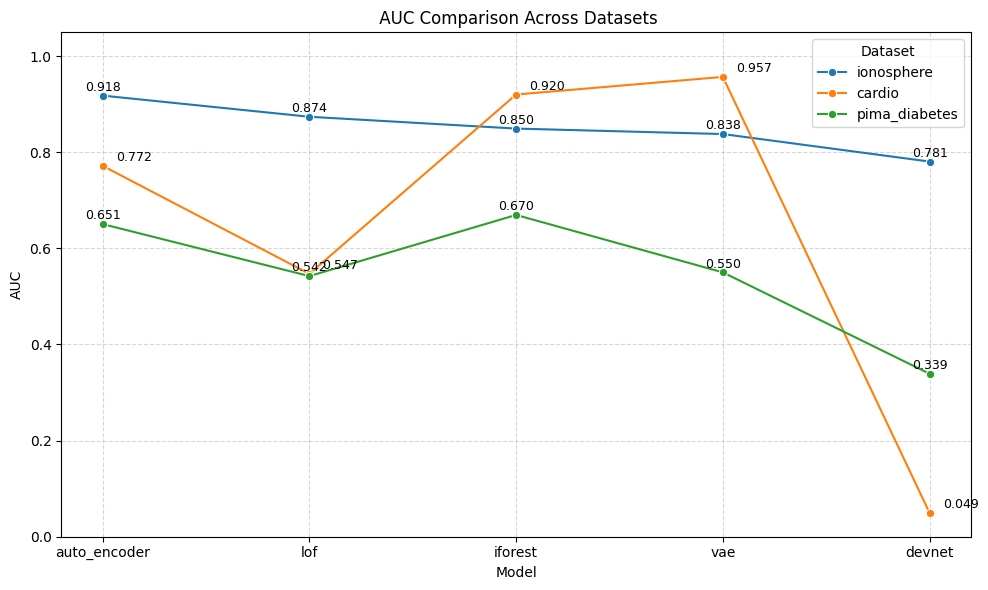

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Convert results to DataFrame
all_results_df = pd.DataFrame(all_results)

# Line plot of model AUCs across datasets
sns.lineplot(data=all_results_df, x="Model", y="AUC", hue="Dataset", marker="o")

# Adjust Y-axis to give headroom
plt.ylim(0.0, 1.05)

# Define custom horizontal jitter for each dataset to reduce label overlap
jitter_map = {
    "ionosphere": 0.0,
    "cardio": 0.15,
    "pima_diabetes": 0.0
}

# Annotate each point with AUC value
for i, row in all_results_df.iterrows():
    x = row["Model"]
    y = row["AUC"]
    jitter = jitter_map.get(row["Dataset"], 0)
    
    # Apply jitter using the index of the model on the x-axis
    x_pos = list(all_results_df["Model"].unique()).index(x) + jitter
    
    plt.text(
        x=x_pos,
        y=y + 0.01,
        s=f"{y:.3f}",
        ha="center",
        fontsize=9
    )

# Labels and layout
plt.title(" AUC Comparison Across Datasets")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


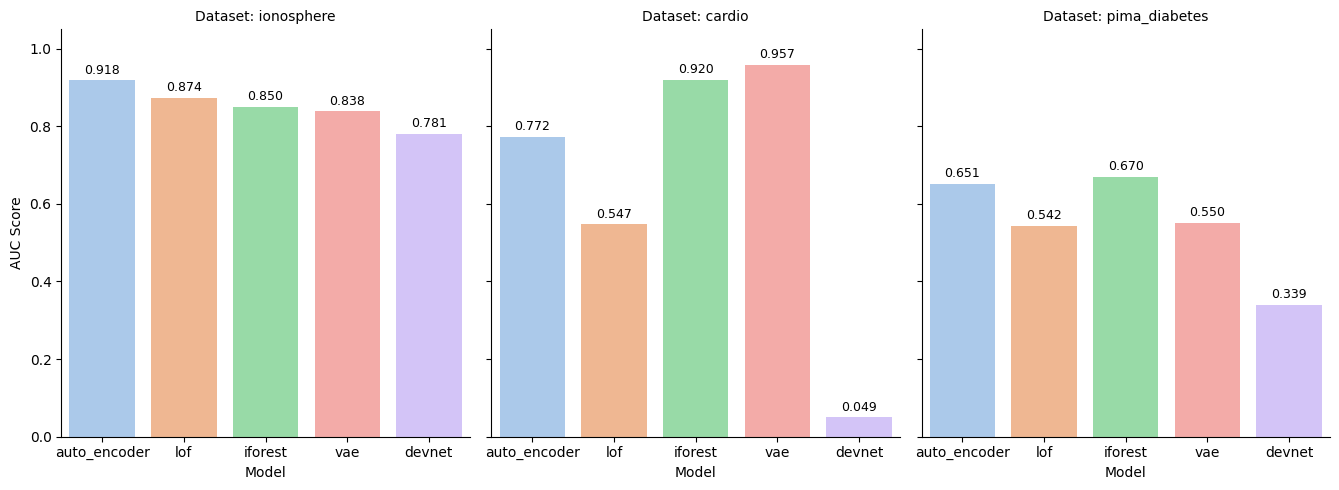

In [25]:
# Grouped bar plots by dataset
g = sns.catplot(
    data=all_results_df,
    x="Model", y="AUC",
    hue="Model", col="Dataset",
    kind="bar", height=5, aspect=0.9,
    palette="pastel"
)

g.set_titles("Dataset: {col_name}")
g.set_axis_labels("Model", "AUC Score")
g.set(ylim=(0.3, 1.05))


# Adjust Y-axis to give headroom
plt.ylim(0.0, 1.05)

# Annotate bars
for ax in g.axes.flat:
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.3f}",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


----------